##Getting Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c nyc-taxi-trip-duration
! unzip nyc-taxi-trip-duration
! unzip test.zip
! unzip train.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 85% 73.0M/85.8M [00:01<00:00, 70.5MB/s]
100% 85.8M/85.8M [00:01<00:00, 60.2MB/s]
Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               
Archive:  test.zip
  inflating: test.csv                
Archive:  train.zip
  inflating: train.csv               


##Spark Installation

In [ ]:
!pip install pyspark
import pyspark
print(pyspark.__version__)
# a SparkSession object can perform the most common data processing tasks
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('test').getOrCreate() # will return existing session if one was
                                                           # created before and was not closed
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=4521aa42cfcec25d8258e5b111d35de0b90d9f3f25d210be60acc09a6fc45d56
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
3.4.0


# Read data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# read train.csv
train_df = pd.read_csv("train.csv")
train_df.sample(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1132,id0558782,2,2016-01-11 00:56:13,2016-01-11 01:01:50,1,-73.987862,40.749393,-73.972740,40.756706,N,337
1124416,id1026503,2,2016-05-28 19:49:59,2016-05-28 19:56:57,2,-73.985474,40.723412,-73.991493,40.714802,N,418
1306882,id3446071,2,2016-05-14 10:52:18,2016-05-14 11:21:48,1,-73.986000,40.745819,-74.008919,40.706200,N,1770
379002,id2173203,2,2016-03-23 13:54:12,2016-03-23 14:18:55,1,-73.982918,40.766850,-73.974960,40.741673,N,1483
1435529,id0074129,1,2016-03-19 09:05:59,2016-03-19 09:09:03,1,-73.901955,40.753860,-73.903107,40.746300,N,184
84296,id1228352,2,2016-02-09 22:40:24,2016-02-09 23:14:47,3,-73.997383,40.741760,-73.957153,40.690769,N,2063
1198998,id0368786,1,2016-06-21 08:23:25,2016-06-21 08:27:18,1,-73.959816,40.762917,-73.957100,40.770824,N,233
239196,id1713516,2,2016-06-08 21:45:38,2016-06-08 21:54:51,1,-74.009407,40.703819,-73.988930,40.700748,N,553
435893,id0832388,1,2016-03-26 13:51:57,2016-03-26 13:54:50,1,-73.971237,40.765026,-73.963768,40.774033,N,173
1440723,id2771587,1,2016-06-07 12:14:39,2016-06-07 12:31:18,1,-73.987976,40.750053,-74.007317,40.736347,N,999


In [ ]:
# explore train.csv
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

# preprocessing data

In [ ]:
#Check for N/A values.
print(train_df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [ ]:
def preprocessing(data_df):
    # remove any rows with missing data
    data_df = data_df.dropna()

    # convert pickup and dropoff datetime to datetime format
    data_df['pickup_datetime'] = pd.to_datetime(data_df['pickup_datetime'])
    data_df['dropoff_datetime'] = pd.to_datetime(data_df['dropoff_datetime'])

    # split datetime into month, day, week and hour
    data_df['day'] = data_df['pickup_datetime'].dt.day
    data_df['hour'] = data_df['pickup_datetime'].dt.hour
    data_df['month'] = data_df['pickup_datetime'].dt.month
    data_df['week'] = data_df['pickup_datetime'].dt.dayofweek
    return data_df


In [ ]:
train_df = preprocessing(train_df)
train_df.sample(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,hour,month,week
759351,id2693183,1,2016-02-23 19:40:45,2016-02-23 20:06:13,2,-73.993286,40.747345,-73.961502,40.760422,N,1528,23,19,2,1
547948,id0920357,2,2016-02-04 19:50:39,2016-02-04 20:07:55,1,-73.978119,40.763691,-73.967789,40.802094,N,1036,4,19,2,3
956191,id3661122,1,2016-03-22 17:09:11,2016-03-22 17:14:01,1,-73.972061,40.791794,-73.960472,40.812469,N,290,22,17,3,1
1153415,id3231995,2,2016-02-24 22:59:32,2016-02-24 23:04:34,1,-73.991470,40.759960,-74.003578,40.740120,N,302,24,22,2,2
242357,id3232156,1,2016-01-03 14:56:40,2016-01-03 15:10:03,2,-73.996002,40.740761,-73.982391,40.765087,N,803,3,14,1,6
363618,id2425340,1,2016-03-13 18:16:37,2016-03-13 18:24:42,1,-73.970177,40.752468,-73.947334,40.771198,N,485,13,18,3,6
1062572,id0701584,2,2016-04-25 17:00:20,2016-04-25 17:12:01,1,-73.978935,40.772243,-73.958298,40.768696,N,701,25,17,4,0
563518,id0010338,1,2016-04-22 16:04:32,2016-04-22 16:14:48,1,-73.955917,40.764477,-73.955261,40.779606,N,616,22,16,4,4
807928,id1696900,2,2016-01-13 18:35:37,2016-01-13 19:07:43,2,-73.991226,40.717216,-73.933777,40.795334,N,1926,13,18,1,2
1431797,id2270826,2,2016-05-08 23:17:30,2016-05-08 23:22:29,1,-74.002190,40.726421,-73.995262,40.749561,N,299,8,23,5,6


In [ ]:
# remove outliers (Time and passenger count)
# < 1 min or > 3 hours
train_df = train_df[~((train_df.trip_duration < 60) | (train_df.trip_duration > 3600*3))]

# dropping trips with passenger count = 0
train_df = train_df[train_df.passenger_count > 0]

# remove outliers (pickup locations) from EDA
train_df = train_df[train_df['pickup_latitude']>37.5]
train_df = train_df[train_df['pickup_latitude']<45]
train_df = train_df[train_df['pickup_longitude']<-65]
train_df = train_df[train_df['pickup_longitude']>-80]

##Feature Extraction

In [ ]:
# Define a UDF to calculate distance between two points using the Haversine formula
import numpy as np

def haversine_distance(lat1, lng1, lat2, lng2):
    R = 6371  # Earth's radius in kilometers

    # Convert latitude and longitude values to radians
    lat1, lng1, lat2, lng2 = np.radians([lat1, lng1, lat2, lng2])

    # Calculate the differences between the two points
    dlat = lat2 - lat1
    dlng = lng2 - lng1

    # Apply the Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    h = R * c

    return h


def manhattan_distance(lat1, lng1, lat2, lng2):
  return abs(lng1-lng2)+abs(lat1-lat2)


def calculate_direction(lat1, lng1, lat2, lng2):
    # Convert coordinates to radians
    lat1, lng1, lat2, lng2 = np.radians([lat1, lng1, lat2, lng2])

    # Calculate the difference in longitude
    lng_delta = lng2 - lng1

    # Calculate the y and x components of the direction vector
    y = np.sin(lng_delta) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta)

    # Calculate the direction in degrees
    direction_degrees = np.degrees(np.arctan2(y, x))

    return direction_degrees


In [ ]:
# compute haversine distance
distance1 = haversine_distance(train_df.pickup_latitude.values, train_df.pickup_longitude.values, train_df.dropoff_latitude.values, train_df.dropoff_longitude.values)

# compute manhattan distance
distance2 = manhattan_distance(train_df.pickup_latitude.values, train_df.pickup_longitude.values, train_df.dropoff_latitude.values, train_df.dropoff_longitude.values)

# compute direction
distance3 = calculate_direction(train_df.pickup_latitude.values, train_df.pickup_longitude.values, train_df.dropoff_latitude.values, train_df.dropoff_longitude.values)
# add haversine_distance / manhattan distance / direction columns to train_df
train_df['haversine_distance'] = distance1
train_df['manhattan_distance'] = distance2
train_df['direction'] = distance3

In [ ]:
train_df.sample(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day,hour,month,week,haversine_distance,manhattan_distance,direction
334438,id1890812,2,2016-03-23 05:43:29,2016-03-23 05:51:26,1,-73.982079,40.731907,-73.993912,40.743374,N,477,23,5,3,2,1.618573,0.023300,-38.018132
823249,id2413698,2,2016-01-23 10:27:14,2016-01-23 10:43:33,1,-73.978958,40.744518,-73.953400,40.767380,N,979,23,10,1,5,3.331165,0.048420,40.251582
490317,id1548332,1,2016-03-08 16:33:32,2016-03-08 16:58:45,1,-73.982574,40.762276,-73.993118,40.725475,N,1513,8,16,3,1,4.187316,0.047344,-167.749205
193748,id1075660,2,2016-06-05 23:07:07,2016-06-05 23:34:03,1,-73.968132,40.800125,-73.955353,40.737484,N,1616,5,23,6,6,7.048025,0.075420,171.212798
1113728,id3227313,2,2016-05-07 17:43:43,2016-05-07 18:01:25,1,-74.009483,40.712730,-73.983627,40.721321,N,1062,7,17,5,5,2.379299,0.034447,66.320807
938710,id2157021,2,2016-05-24 18:58:21,2016-05-24 19:05:30,1,-73.955437,40.779724,-73.952576,40.789501,N,429,24,18,5,1,1.113526,0.012638,12.492129
561637,id0231177,2,2016-05-17 13:05:11,2016-05-17 13:13:04,1,-73.986252,40.752079,-73.980743,40.759571,N,473,17,13,5,1,0.953569,0.013000,29.113337
752215,id1527844,2,2016-04-20 19:47:14,2016-04-20 19:54:59,1,-73.991257,40.733376,-73.978493,40.731091,N,465,20,19,4,2,1.105097,0.015049,103.288038
98077,id3381924,1,2016-05-19 12:49:25,2016-05-19 13:26:51,1,-73.968132,40.791401,-73.957520,40.764286,N,2246,19,12,5,3,3.144670,0.037727,163.487808
289049,id0487056,1,2016-01-27 10:50:24,2016-01-27 11:10:41,1,-73.955154,40.780277,-74.012344,40.701420,N,1217,27,10,1,2,10.005117,0.136047,-151.193150


##Convert categorical data

In [ ]:
# Define numerical and categorical columns
numerical_cols = ['haversine_distance', 'manhattan_distance', 'direction']
categorical_cols = ['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'day', 'hour', 'month', 'week']

# Encode categorical data into numerical data using one-hot encoding
def encode_categorical(df):
    for categorical in categorical_cols:
        encoded_cat = pd.get_dummies(df[categorical], prefix=categorical, prefix_sep='_')
        df = (df.drop([categorical], axis=1)).join(encoded_cat)
    return df
# Apply encoding to training and test data
train_df = encode_categorical(train_df)

In [ ]:
train_df.sample(10)

,id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,haversine_distance,manhattan_distance,...,month_4,month_5,month_6,week_0,week_1,week_2,week_3,week_4,week_5,week_6
908143,id3350586,2016-02-09 22:24:42,2016-02-09 22:30:08,-73.970734,40.758362,-73.981056,40.744492,326,1.770528,0.024193,...,0,0,0,0,1,0,0,0,0,0
371045,id1736350,2016-03-01 22:27:50,2016-03-01 22:56:49,-74.008270,40.715771,-73.956604,40.747875,1739,5.629933,0.083771,...,0,0,0,0,1,0,0,0,0,0
929049,id3215797,2016-05-31 14:04:55,2016-05-31 14:26:12,-73.981880,40.783291,-73.962769,40.768162,1277,2.328063,0.034241,...,0,1,0,0,1,0,0,0,0,0
816668,id2951008,2016-02-13 11:57:29,2016-02-13 12:04:58,-74.003517,40.732590,-74.000755,40.723915,449,0.992252,0.011436,...,0,0,0,0,0,0,0,0,1,0
947196,id1637284,2016-01-16 19:26:32,2016-01-16 19:45:16,-73.980431,40.783318,-73.991257,40.746250,1124,4.221349,0.047894,...,0,0,0,0,0,0,0,0,1,0
494504,id3822756,2016-05-08 00:06:09,2016-05-08 00:15:02,-73.987991,40.759701,-73.976929,40.784931,533,2.956116,0.036293,...,0,1,0,0,0,0,0,0,0,1
53438,id2653891,2016-04-13 21:39:32,2016-04-13 21:47:26,-73.950623,40.786518,-73.938988,40.804829,474,2.259361,0.029945,...,1,0,0,0,0,1,0,0,0,0
1301231,id1700799,2016-05-15 22:23:01,2016-05-15 22:26:31,-74.005157,40.741047,-74.006256,40.733425,210,0.852542,0.008720,...,0,1,0,0,0,0,0,0,0,1
546600,id2958147,2016-06-15 00:57:02,2016-06-15 01:03:16,-73.999916,40.718754,-74.001694,40.739536,374,2.315755,0.022560,...,0,0,1,0,0,1,0,0,0,0
864672,id1572672,2016-04-03 17:37:58,2016-04-03 17:59:49,-73.870689,40.773598,-73.960762,40.769585,1311,7.598133,0.094086,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
train_df.columns

Index(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'haversine_distance', 'manhattan_distance',
       'direction', 'vendor_id_1', 'vendor_id_2', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'passenger_count_8',
       'passenger_count_9', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', '

In [ ]:
dftrainNew = train_df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime'], axis=1)

In [ ]:
dftrainNew.columns

Index(['trip_duration', 'haversine_distance', 'manhattan_distance',
       'direction', 'vendor_id_1', 'vendor_id_2', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'passenger_count_8',
       'passenger_count_9', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'month_1', 'month_2', 'mont

In [ ]:
dftrainNew.sample(10)

,trip_duration,haversine_distance,manhattan_distance,direction,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,...,month_4,month_5,month_6,week_0,week_1,week_2,week_3,week_4,week_5,week_6
196187,1958,18.803662,0.273540,-114.777633,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
999816,491,0.720535,0.010727,51.732311,0,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1122813,985,2.087773,0.028893,-148.839206,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
852316,1091,1.988427,0.029575,55.703561,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
442244,168,0.916872,0.012535,-150.535357,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
705433,2048,4.234523,0.041470,-176.028287,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1361715,1562,4.239200,0.062729,59.368239,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
238160,279,1.123103,0.016708,124.033073,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
485269,358,1.209731,0.011707,176.619677,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1214423,988,2.155526,0.020847,176.648345,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# correlation matrix
corr_matrix = train_df.corr()
corr_matrix["trip_duration"].sort_values(ascending=False)

<ipython-input-20-d15c48e41a55>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr()


trip_duration         1.000000
haversine_distance    0.739478
manhattan_distance    0.726638
pickup_longitude      0.345963
dropoff_longitude     0.205905
                        ...   
week_5               -0.037842
hour_6               -0.038309
week_6               -0.044178
dropoff_latitude     -0.175865
pickup_latitude      -0.231876
Name: trip_duration, Length: 88, dtype: float64

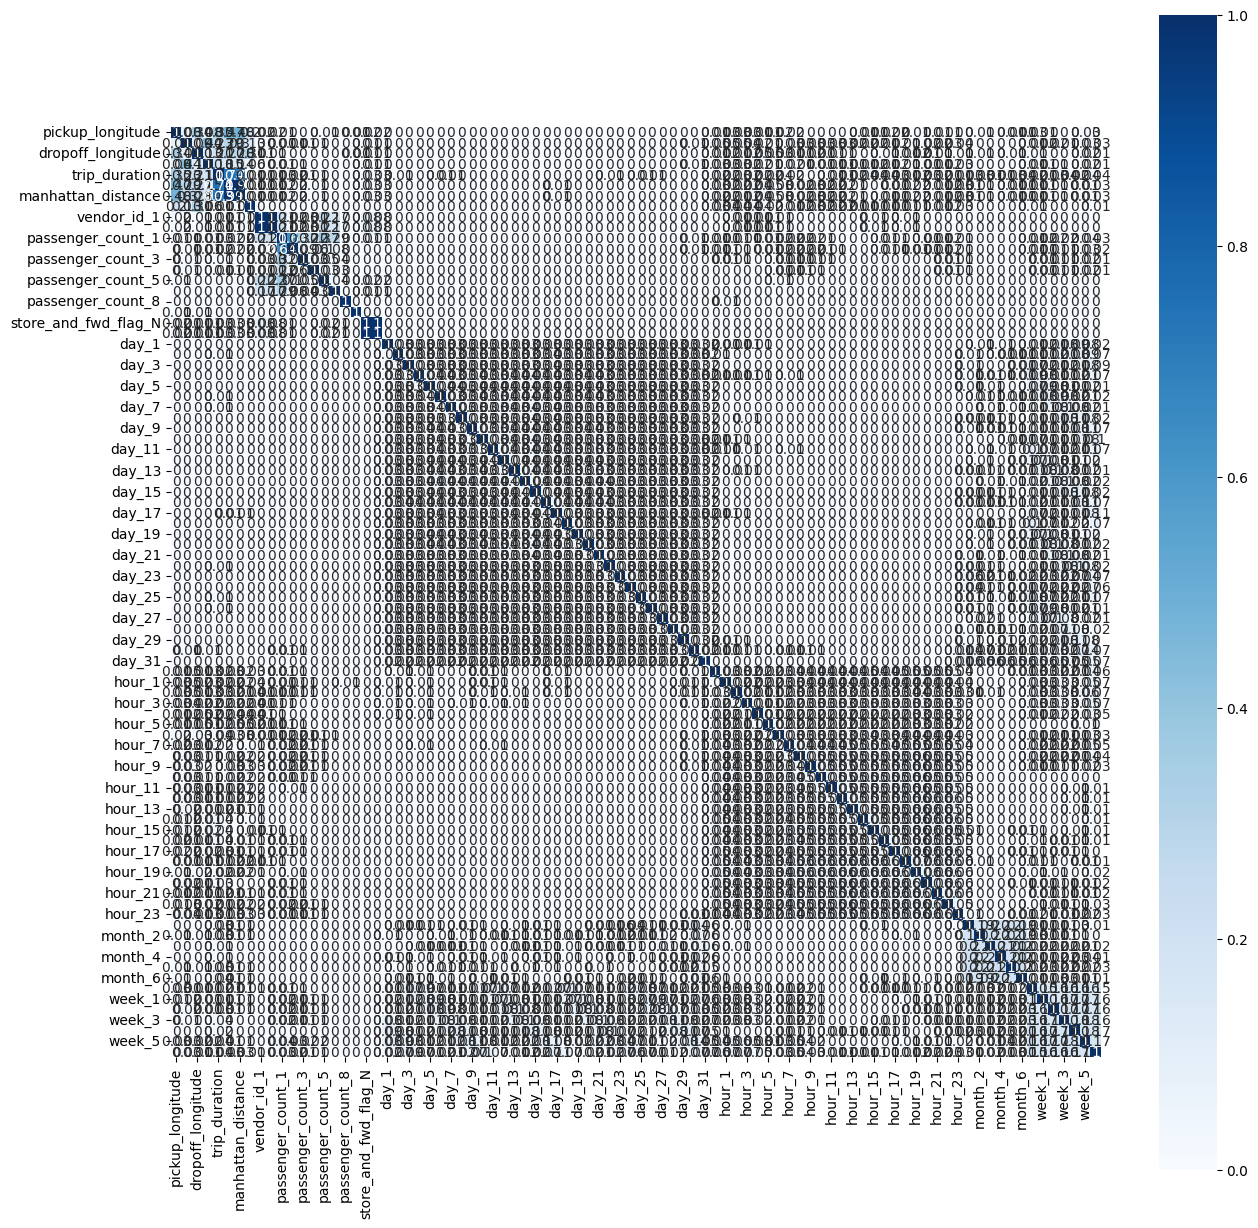

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(np.round(corr_matrix, 2)), square=True, annot=True, cmap=plt.cm.Blues)
plt.show()

##saving final features 

In [ ]:
dftrainNew.to_csv('data.csv', index=False)

#Model

##Convert to spark

In [ ]:
dfspark = spark.read.option('header','true').csv('data.csv')
from pyspark.sql.functions import col

# cast all columns to float
for col_name in dfspark.columns:
    dfspark = dfspark.withColumn(col_name, col(col_name).cast('float'))


In [ ]:
dfspark.show(3)

+-------------+------------------+------------------+----------+-----------+-----------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+--------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+
|trip_duration|haversine_distance|manhattan_distance| direction|vendor_id_1|vendor_id_2|passenger_count_1|passenger_count_2|passenger_count_3|passenger_count_4|passenger_count_5|passenger_count_6|passenger_count_8|passenger_count_9|store_

In [ ]:
# devide dataset to training features and target

X_column_names = dfspark.columns
target_colum_name = ['trip_duration']

# remove 'trip_duration' from X_column_names
X_column_names.remove('trip_duration')

print(X_column_names)


['haversine_distance', 'manhattan_distance', 'direction', 'vendor_id_1', 'vendor_id_2', 'passenger_count_1', 'passenger_count_2', 'passenger_count_3', 'passenger_count_4', 'passenger_count_5', 'passenger_count_6', 'passenger_count_8', 'passenger_count_9', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6']


In [ ]:
# convert feature columns into a columns where the vlues are feature vectors
from pyspark.ml.feature import VectorAssembler
v_asmblr = VectorAssembler(inputCols=X_column_names, outputCol='Fvec')
df = v_asmblr.transform(dfspark)
X = df.select(['Fvec','trip_duration'])
X.show(3)

+--------------------+-------------+
|                Fvec|trip_duration|
+--------------------+-------------+
|(83,[0,1,2,4,5,13...|        455.0|
|(83,[0,1,2,3,5,13...|        663.0|
|(83,[0,1,2,4,5,13...|       2124.0|
+--------------------+-------------+
only showing top 3 rows



In [ ]:
print(type(X))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
X.tail(3)

[Row(Fvec=SparseVector(83, {0: 7.8246, 1: 0.1067, 2: -150.7885, 4: 1.0, 5: 1.0, 13: 1.0, 36: 1.0, 52: 1.0, 73: 1.0, 80: 1.0}), trip_duration=764.0),
 Row(Fvec=SparseVector(83, {0: 1.0926, 1: 0.0155, 2: 35.0333, 3: 1.0, 5: 1.0, 13: 1.0, 19: 1.0, 61: 1.0, 70: 1.0, 77: 1.0}), trip_duration=373.0),
 Row(Fvec=SparseVector(83, {0: 1.134, 1: 0.0156, 2: 29.9695, 3: 1.0, 5: 1.0, 13: 1.0, 19: 1.0, 60: 1.0, 73: 1.0, 77: 1.0}), trip_duration=198.0)]

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = X.randomSplit([0.8,0.2])

In [ ]:
train_df.tail(3)

[Row(Fvec=SparseVector(83, {4: 1.0, 10: 1.0, 13: 1.0, 40: 1.0, 65: 1.0, 74: 1.0, 79: 1.0}), trip_duration=435.0),
 Row(Fvec=SparseVector(83, {4: 1.0, 10: 1.0, 13: 1.0, 42: 1.0, 64: 1.0, 74: 1.0, 81: 1.0}), trip_duration=1208.0),
 Row(Fvec=SparseVector(83, {4: 1.0, 10: 1.0, 13: 1.0, 44: 1.0, 64: 1.0, 75: 1.0, 79: 1.0}), trip_duration=636.0)]

In [ ]:
train_df.head()

Row(Fvec=SparseVector(83, {0: 0.3015, 1: 0.0043, 2: 144.2662, 3: 1.0, 5: 1.0, 13: 1.0, 15: 1.0, 46: 1.0, 70: 1.0, 80: 1.0}), trip_duration=221.0)

In [ ]:
test_df.head()

Row(Fvec=SparseVector(83, {0: 0.2448, 1: 0.0032, 2: 98.5672, 3: 1.0, 5: 1.0, 13: 1.0, 15: 1.0, 46: 1.0, 70: 1.0, 80: 1.0}), trip_duration=198.0)

In [ ]:
# a_df = spark.read.option('header','true').csv('ab.csv')
# for col_name in a_df.columns:
#     a_df = a_df.withColumn(col_name, col(col_name).cast('float'))


# co_names = ['f_1','f_2','f_3']
# from pyspark.ml.feature import VectorAssembler
# asse_a = VectorAssembler(inputCols=co_names, outputCol='features')
# df_a = asse_a.transform(a_df)
# X_a = df_a.select(['features','label'])
# X_a.show(3)



In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.appName("MyApp").getOrCreate()

# data = [
#     ([1, 2, 3], 5),
#     ([4, 5], 10),
#     ([6, 7, 8], 15),
#     ([9, 10, 11, 12], 20)
# ]

# df = spark.createDataFrame(data, ["values", "num"])
# result = X_a.rdd.map(lambda row: (sum(row.features), row.label)).map(lambda t: t[0] * t[1]).reduce(lambda x, y: x + y)

# print(result)

In [ ]:
# X_a.head()

In [ ]:
# def sum_partition(iterator):
#     yield sum(iterator)

# rdd = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8], 4) # create an RDD with 4 partitions
# rdd_map = rdd.mapPartitions(sum_partition) # apply the sum_partition function to each partition
# print(rdd_map.collect()) # [3, 7, 11, 15]



# def m_f(rows):
#   for row in rows:
#     yield row.features[1]
# def r_f(v1 , v2):
#   print(v1)
#   return v1+v2
  
# aa = X_a.rdd.mapPartitions(m_f).reduce(r_f)
# print(aa)


## Building Linear Regression Using Map Reduce

In [ ]:
# from matplotlib import gridspec
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import DenseVector


# class LinearRegressionMR:
#     def __init__(self, spark, features_col, label_col, max_iter=100, reg_param=0.01, elastic_net_param=0.0):
#         self.spark = spark
#         self.weights = None
#         self.features_col = features_col
#         self.label_col = label_col
#         self.max_iter = max_iter
#         self.reg_param = reg_param
#         self.elastic_net_param = elastic_net_param

#     def train(self, train_data):

# # from pyspark.ml.feature import VectorAssembler
# # v_asmblr = VectorAssembler(inputCols=X_column_names, outputCol='Fvec')
# # df = v_asmblr.transform(dfspark)
# # X = df.select(['Fvec','trip_duration'])
# # X.show(3)

#         # assembler = VectorAssembler(inputCols=train_data.columns[:-1], outputCol=self.features_col)
#         # train_data = assembler.transform(train_data)
#         # train_data = train_data.select(self.features_col, self.label_col)

#         train_data = X
#         print(X)
#         num_features = len(train_data.select(self.features_col).first()[0])
#         print(num_features)
#         self.weights = [0.0] * num_features
#         print(self.weights)
#         for _ in range(self.max_iter):
#           print("itr")
#           # global_gradient_loss = train_data.rdd.mapPartitions(
#           #     lambda data_points: self._map_func(data_points, self.weights, self.reg_param)
#           # ).reduce(self._reduce_func)

#           global_gradient_loss = train_data.rdd.mapPartitions(
#               self._map_func
#           ).reduce(self._reduce_func)
#             # self.weights = [w - global_gradient_loss[0][i] for i, w in enumerate(self.weights)]

#     def predict(self, test_data):
#         # assembler = VectorAssembler(inputCols=test_data.columns[:-1], outputCol=self.features_col)
#         # test_data = assembler.transform(test_data)
#         test_data = test_data.columns[:-1]
#         predictions = test_data.rdd.map(lambda row: self._predict_func(row, self.weights))
#         return self.spark.createDataFrame(predictions, ["prediction"])

#     def _map_func(self, data_points):#, weights, reg_param):
#         print("SS")
#         # local_gradients = []
#         # local_losses = []
#         # for features, target in data_points:
#         #     prediction = DenseVector(weights).dot(DenseVector(features))
#         #     gradient = [(prediction - target) * feature for feature in features]
#         #     loss = (prediction - target) ** 2
#         #     local_gradients.append(gradient)
#         #     local_losses.append(loss)
#         # global_gradient = [sum(grad) / len(grad) for grad in zip(*local_gradients)]
#         # global_loss = sum(local_losses) / len(local_losses)
#         # regularized_gradient = [grad + reg_param * weight for grad, weight in zip(global_gradient, weights)]
#         # yield [(regularized_gradient, global_loss)]
#         for a in data_points:
#           yield 1 

#     def _reduce_func(self, gradient_loss1, gradient_loss2):
#         # gradient_sum = [grad1 + grad2 for grad1, grad2 in zip(gradient_loss1[0], gradient_loss2[0])]
#         # loss_sum = gradient_loss1[1] + gradient_loss2[1]
#         # return (gradient_sum, loss_sum)
#         return gradient_loss1 + gradient_loss2

#     @staticmethod
#     def _predict_func(row, weights):
#         features = row[0]
#         prediction = DenseVector(weights).dot(DenseVector(features))
#         return (prediction,)











In [ ]:
from matplotlib import gridspec
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import DenseVector

In [ ]:
# a = DenseVector([1,2,3])
# b = DenseVector([4,5,6])
# c = a.dot(b)
# print(c)

## Building the model

In [ ]:
spark = None
features_col = None
label_col = None
max_iter = None
reg_param = None
elastic_net_param = None

weights = None

def LinearRegressionMR(spark_ = None , features_col_ = None , label_col_ = None , max_iter_ = None , reg_param_ = None ,elastic_net_param_ = None):
  global spark
  spark = spark_
  global features_col
  features_col = features_col_
  global label_col
  label_col = label_col_ 
  global max_iter
  max_iter = max_iter_
  global reg_param
  reg_param = reg_param_
  global elastic_net_param
  elastic_net_param = elastic_net_param_

def map_func(data_points, weights, reg_param):
  for features, target in data_points:
    prediction = DenseVector(weights).dot(DenseVector(features))
    gradient = [(prediction - target) * feature for feature in features]
    yield gradient

def reduce_func(gradient_loss1, gradient_loss2):
    gradient_sum = [grad1 + grad2 for grad1, grad2 in zip(gradient_loss1, gradient_loss2)]
    return gradient_sum

def fitMR(train_data , num_features = 83 , learning_rate = 0.01):
  global weights
  weights = [0.0] * num_features
  for _ in range(max_iter):
    print(_)
    global_gradient = train_data.rdd.mapPartitions(lambda data_points: map_func(data_points, weights, reg_param)).reduce(reduce_func)
    for i in range(len(global_gradient)):
      global_gradient[i] = global_gradient[i]/974
    print(global_gradient)
    weights = [w - learning_rate * (global_gradient[i]) for i, w in enumerate(weights)]
    print(weights)

In [ ]:
print(type(train_df))
sampled_df = train_df.sample(False, fraction=1000 / train_df.count())

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
sampled_df.count()

974

In [ ]:
LinearRegressionMR(spark, features_col_="Fvec", label_col_="trip_duration",max_iter_=3, reg_param_=0.001, elastic_net_param_=0.8)
fitMR(sampled_df)

0
[-4867.777575627719, -66.74427647365437, 3025.288020572162, -363.6981519507187, -460.1848049281314, -565.3039014373717, -118.65503080082135, -44.26283367556468, -15.956878850102669, -47.48254620123203, -32.2217659137577, -0.0, -0.0, -821.9712525667351, -1.9117043121149897, -26.64681724845996, -26.5564681724846, -19.530800821355236, -26.248459958932237, -26.3305954825462, -23.455852156057496, -32.60369609856263, -19.607802874743328, -32.47946611909651, -24.747433264887064, -16.53593429158111, -21.09753593429158, -38.284394250513344, -32.152977412731005, -30.198151950718685, -31.946611909650922, -31.756673511293634, -31.075975359342916, -27.4958932238193, -30.61088295687885, -20.591375770020534, -19.54312114989733, -20.980492813141684, -28.075975359342916, -32.94866529774127, -39.21252566735113, -39.49075975359343, -14.678644763860369, -23.82751540041068, -20.1129363449692, -15.058521560574949, -24.38501026694045, -18.66016427104723, -12.80800821355236, -11.899383983572895, -6.89835728

In [ ]:
samples_test_df = test_df.sample(False, fraction=200 / test_df.count())

In [ ]:
spark = SparkSession.builder.appName("MyApp").getOrCreate()
def predict_map_func(row, weights):
        features = row[0]
        features = DenseVector(features)
        float_reatures = list(features.toArray().astype(float))
        features = DenseVector(features)
        prediction = DenseVector(weights).dot(DenseVector(features))
        return prediction

def predict(test_data):
    weights_ = list(map(float,weights))
    predictions = test_data.rdd.map(lambda row: predict_map_func(row, weights_))
    
    return predictions





In [ ]:
weights = list(map(float,weights))

In [ ]:
y_pred = predict(samples_test_df)

In [ ]:
y_pred = y_pred.collect()

In [ ]:
# print(weights)

In [ ]:
# print(y_pred)

In [ ]:
column_values = samples_test_df.select("trip_duration").rdd.flatMap(lambda x: x).collect()
y_test = [row for row in column_values]
print(y_test)

[1233.0, 552.0, 899.0, 2775.0, 484.0, 592.0, 648.0, 380.0, 610.0, 634.0, 1814.0, 728.0, 857.0, 962.0, 502.0, 658.0, 944.0, 1733.0, 398.0, 714.0, 950.0, 175.0, 676.0, 434.0, 1527.0, 767.0, 959.0, 792.0, 162.0, 301.0, 403.0, 389.0, 1341.0, 1144.0, 315.0, 918.0, 778.0, 232.0, 830.0, 1681.0, 383.0, 392.0, 478.0, 256.0, 307.0, 489.0, 831.0, 3722.0, 266.0, 1054.0, 375.0, 439.0, 797.0, 147.0, 311.0, 262.0, 1126.0, 1785.0, 648.0, 535.0, 1103.0, 128.0, 736.0, 962.0, 1424.0, 200.0, 861.0, 908.0, 635.0, 1952.0, 275.0, 1055.0, 1151.0, 323.0, 840.0, 199.0, 593.0, 524.0, 3681.0, 616.0, 606.0, 1031.0, 783.0, 548.0, 196.0, 546.0, 569.0, 302.0, 559.0, 571.0, 1054.0, 209.0, 1199.0, 625.0, 1799.0, 327.0, 365.0, 977.0, 459.0, 931.0, 484.0, 1575.0, 861.0, 1721.0, 1046.0, 279.0, 306.0, 148.0, 292.0, 317.0, 1628.0, 258.0, 841.0, 4724.0, 511.0, 323.0, 929.0, 463.0, 527.0, 453.0, 779.0, 2202.0, 226.0, 302.0, 226.0, 1672.0, 1304.0, 488.0, 628.0, 1141.0, 310.0, 325.0, 932.0, 1228.0, 1096.0, 1005.0, 1492.0, 232.0

In [ ]:
# from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error (MSE):", mse)

# from sklearn.metrics import mean_squared_error

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print("Root Mean Squared Error (RMSE):", rmse)

# from sklearn.metrics import mean_absolute_error

# mae = mean_absolute_error(y_test, y_pred)
# print("Mean Absolute Error (MAE):", mae)

# from sklearn.metrics import r2_score

# r2 = r2_score(y_test, y_pred)
# print("R-squared (R2):", r2)


##1- Linear regression

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'Fvec', labelCol='trip_duration', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [65.83326522113298,2904.077775383094,0.08487183876882207,-0.2565178900448294,0.2565178900411483,0.0,-11.51321679118828,15.876930168560515,19.75007242085877,31.851409407957537,-6.4216058435391865,-2.4591820711771444,-615.261711105876,0.0,-38.26093445121344,38.26093445111288,-21.497924570870552,-22.301166972517976,-8.327403003020844,-11.419587488667382,-11.999220251178365,-10.806555827402507,-23.100261254854008,-0.6876782469698036,-5.847645914185283,-12.80572974219198,-5.585967066155194,9.38702594513902,5.5332318104481555,9.881170621046744,-5.98174198639674,7.615720046510708,2.0337504569921014,-0.0,1.2332005024155652,3.1062648413940352,12.919656513449947,9.87480954139377,2.710443322791042,0.0,9.112609536654343,28.73362404704679,2.0300921385200663,-13.633710294514138,-8.248532391305273,-20.025597183456416,0.0,-97.61681147612286,-125.5990776039402,-147.09326535223178,-170.77828631548851,-228.3754080940505,-333.0820952121945,-249.6473752908115,-86.78976485909054,29.92242093164

In [ ]:
lr_model.evaluate(test_df).predictions.tail(20)

[Row(Fvec=SparseVector(84, {4: 1.0, 7: 1.0, 14: 1.0, 44: 1.0, 59: 1.0, 72: 1.0, 77: 1.0}), trip_duration=552.0, prediction=494.71855896182535),
 Row(Fvec=SparseVector(84, {4: 1.0, 8: 1.0, 14: 1.0, 31: 1.0, 69: 1.0, 71: 1.0, 82: 1.0}), trip_duration=67.0, prediction=362.83864137552223),
 Row(Fvec=SparseVector(84, {4: 1.0, 8: 1.0, 14: 1.0, 41: 1.0, 48: 1.0, 73: 1.0, 82: 1.0}), trip_duration=527.0, prediction=349.52874566718225),
 Row(Fvec=SparseVector(84, {4: 1.0, 8: 1.0, 14: 1.0, 43: 1.0, 59: 1.0, 76: 1.0, 78: 1.0}), trip_duration=287.0, prediction=643.0424031303575),
 Row(Fvec=SparseVector(84, {4: 1.0, 9: 1.0, 14: 1.0, 32: 1.0, 66: 1.0, 75: 1.0, 78: 1.0}), trip_duration=289.0, prediction=570.3973344198776),
 Row(Fvec=SparseVector(84, {4: 1.0, 10: 1.0, 14: 1.0, 16: 1.0, 59: 1.0, 74: 1.0, 81: 1.0}), trip_duration=244.0, prediction=594.1559183481381),
 Row(Fvec=SparseVector(84, {4: 1.0, 10: 1.0, 14: 1.0, 19: 1.0, 55: 1.0, 73: 1.0, 81: 1.0}), trip_duration=627.0, prediction=517.50969888017

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# assuming you have already trained a linear regression model called 'lr_model' on your training data

# make predictions on the test data
predictions = lr_model.transform(test_df)

# create an evaluator for regression problems and set the label and prediction columns
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')

# evaluate the model's root mean squared error (RMSE) on the test data
rmse = evaluator.evaluate(predictions)

# print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


Root Mean Squared Error (RMSE) on test data = 414.42161779688126


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming `predictions` is a DataFrame containing the predictions of your model on the test data
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='trip_duration', metricName='r2')
r2_score = evaluator.evaluate(predictions)

print('R-squared score on test data:', r2_score)


R-squared score on test data: 0.601951312535913


##2- Decision Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

# create a decision tree regression model and set its parameters
dt_model = DecisionTreeRegressor(featuresCol='Fvec', labelCol='trip_duration', maxDepth=10)

# train the model on your training data
dt_model = dt_model.fit(train_df)

# make predictions on the test data
predictions = dt_model.transform(test_df)

# evaluate the model's root mean squared error (RMSE) on the test data
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


Root Mean Squared Error (RMSE) on test data = 375.41748614712577


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming `predictions` is a DataFrame containing the predictions of your model on the test data
evaluator_r2 = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions)

print('R-squared score on test data:', r2_score)


R-squared score on test data: 0.601951312535913


##3- Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# create a random forest regression model and set its parameters
rf_model = RandomForestRegressor(featuresCol='Fvec', labelCol='trip_duration', numTrees=100, maxDepth=10)

# train the model on your training data
rf_model = rf_model.fit(train_df)

# make predictions on the test data
predictions = rf_model.transform(test_df)

# evaluate the model's root mean squared error (RMSE) on the test data
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assuming `predictions` is a DataFrame containing the predictions of your model on the test data
evaluator_r2 = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions)

print('R-squared score on test data:', r2_score)


##4- XGBoost 

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create an XGBoost regression model
xgb_model = GBTRegressor(featuresCol='Fvec', labelCol='trip_duration', maxDepth=10)

# Train the model on your training data
xgb_model = xgb_model.fit(train_df)

# Make predictions on the test data
predictions = xgb_model.transform(test_df)

# Evaluate the model's root mean squared error (RMSE) on the test data
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Evaluate the model's R-squared score on the test data
evaluator_r2 = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions)

print('R-squared score on test data:', r2)


Root Mean Squared Error (RMSE) on test data = 337.25024577350376
R-squared score on test data: 0.7363936047199996


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create an XGBoost regression model
xgb_model = GBTRegressor(featuresCol='Fvec', labelCol='trip_duration')

# Train the model on your training data
xgb_model = xgb_model.fit(train_df)

# Make predictions on the test data
predictions = xgb_model.transform(test_df)

# Evaluate the model's root mean squared error (RMSE) on the test data
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

# Evaluate the model's R-squared score on the test data
evaluator_r2 = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='r2')
r2 = evaluator_r2.evaluate(predictions)

print('R-squared score on test data:', r2)


Root Mean Squared Error (RMSE) on test data = 306.57279154861004
R-squared score on test data: 0.78699982650488
